### Goal: align `gpudrive` _json scenarios_ with `waymax`

- Got the same scenario (`2bd577a009790706`)
- Let's look at the raw data

In [1]:
import os
import waymax
import json
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

import gpudrive
from pygpudrive.env.config import SceneConfig
from pygpudrive.env.scene_selector import select_scenes

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (7, 2)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'png'

### Configurations

In [2]:
DATA_DIR = 'data/processed' # Base data path
CKPT_DIR = 'data/checkpoints' # Base checkpoint path

SCENARIO_ID = '2bd577a009790706' # Debugging scenario we use 
CKPT_PATH = 'integrations/models/vbd/weights/epoch=18.ckpt'

TRAJ_LEN = 91 # Length of the trajectory
MAX_NUM_AGENTS = gpudrive.kMaxAgentCount

CMAP = 'bwr'

### Load scenarios

- We load an idential scenario both in waymax and gpudrive so that we can do a like for like comparison

In [3]:
# same scenario in gpudrive
sim = gpudrive.SimManager( 
    exec_mode=gpudrive.madrona.ExecMode.CPU, 
    scenes=select_scenes(SceneConfig("data/processed/debug/gpudrive", 1)),
    gpu_id=0,
    params=gpudrive.Parameters(),
)


--- Ratio unique scenes / number of worls =         1 / 1 ---



In [4]:
# scenario in waymax
with open(f'{DATA_DIR}/debug/waymax/waymax_scenario_{SCENARIO_ID}.pkl', 'rb') as f:
    waymax_scenario = pickle.load(f)
    
# raw json scenario
with open(f'data/processed/debug/gpudrive/tfrecord-00005-of-00150_{SCENARIO_ID}.json') as file:
    json_scenario = json.load(file)

2024-11-07 15:57:00.457817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 15:57:00.465289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 15:57:00.467534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 15:57:01.007725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Agent ordering (todo)

- How are the ids assigned in `waymax`?
    - The ids attribute assigns a unique ID to each object.
    - These are taken directly from `state/id` https://waymo.com/open/data/motion/tfexample 

In [39]:
json_agent_ids = []

for obj in json_scenario['objects']:
    if 'id' in obj:
        json_agent_ids.append(obj['id'])
            
json_agent_ids = np.array(json_agent_ids)

# Get the sorted agent indices
waymax_sorted_agent_idx = np.argsort(waymax_scenario.object_metadata.ids)[::-1]
gpudrive_sorted_agent_idx = np.argsort(json_agent_ids)[::-1]

waymax_scenario.object_metadata.ids[waymax_sorted_agent_idx]

Array([3843, 3842, 3841, 3839, 3775, 3774, 3766, 3750,  998,  997,  996,
        995,  994,  993,  992,  990,  989,  988,  987,  986,  985,  983,
        980,  979,  978,  977,  976,  973,  971,  968,  966,  964,  962,
        961,  960,  959,  957,  953,  951,  944,  943,  942,  940,  939,
        937,  927,  926,  918,  916,  915,  914,  912,  909,  907,  906,
        905,  904,  903,  902,  901,  900,  899,  898,  897,  896,   -1,
         -1,   -1,   -1,   -1], dtype=int32)

In [40]:
json_agent_ids[gpudrive_sorted_agent_idx]

array([3843, 3842, 3841, 3839, 3775, 3774, 3766, 3750,  998,  997,  996,
        995,  994,  993,  992,  990,  989,  988,  987,  986,  985,  983,
        980,  979,  978,  977,  976,  973,  971,  968,  966,  964,  962,
        961,  960,  959,  957,  953,  951,  944,  943,  942,  940,  939,
        937,  927,  926,  918,  916,  915,  914,  912,  909,  907,  906,
        905,  904,  903,  902,  901,  900,  899,  898,  897,  896])

### Yaw 

> Main Q: Is `math.degrees(state.heading)` the same as `bbox_yaw`?

- Waymax:
    - Link: [in waymax](https://github.com/waymo-research/waymax/blob/720f9214a9bf79b3da7926497f0cd0468ca3e630/waymax/dataloader/womd_factories.py#L234C3-L234C15) they take the yaw directly from `bbox_yaw` [[tfexample data](https://waymo.com/open/data/motion/tfexample)]
- Raw json scenario
    - Processed from protobuf in `data_utils/process_waymo_files.py`
    
- GPUDrive (todo)
    - How is the json yaw info processed in GPUDrive? How can we align it with waymax?

In [5]:
def wrap_yaws(yaws):
  """Wraps yaw angles between pi and -pi radians."""
  return (yaws + np.pi) % (2 * np.pi) - np.pi

In [6]:
waymax_yaw = waymax_scenario.log_trajectory.yaw

# Note that the waymax yaw is in radians from -pi to pi
waymax_yaw.shape, waymax_yaw.min(), waymax_yaw.max()

((70, 91), Array(-3.1391213, dtype=float32), Array(3.140661, dtype=float32))

In [7]:
json_yaws = []
for obj in json_scenario['objects']:
    if 'heading' in obj:
        json_yaws.append(obj['heading'])
json_yaws = np.array(json_yaws)
json_yaws.shape

(65, 91)

In [8]:
sim.expert_trajectory_tensor().to_torch().shape

torch.Size([1, 70, 1456])

In [12]:
gpudrive_log_trajectory = sim.expert_trajectory_tensor().to_torch()

sim_pos_xy = gpudrive_log_trajectory[:, :, : 2 * TRAJ_LEN].reshape(1, MAX_NUM_AGENTS, TRAJ_LEN, -1).squeeze(0)
sim_vel_xy = gpudrive_log_trajectory[:, :, 2 * TRAJ_LEN : 4 * TRAJ_LEN].view(1, MAX_NUM_AGENTS, TRAJ_LEN, -1).squeeze(0)
sim_yaw_xy = gpudrive_log_trajectory[:, :, 4 * TRAJ_LEN : 5 * TRAJ_LEN].view(1, MAX_NUM_AGENTS, TRAJ_LEN, -1).squeeze(0, -1)

sim_pos_xy.shape, sim_vel_xy.shape, sim_yaw_xy.shape

(torch.Size([70, 91, 2]), torch.Size([70, 91, 2]), torch.Size([70, 91]))

/home/emerge/.pyenv/versions/3.10.12/envs/gdrive/lib/python3.10/site-packages/matplotlib/colors.py:1404: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/emerge/.pyenv/versions/3.10.12/envs/gdrive/lib/python3.10/site-packages/matplotlib/colors.py:1404: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/emerge/.pyenv/versions/3.10.12/envs/gdrive/lib/python3.10/site-packages/matplotlib/colors.py:1404: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


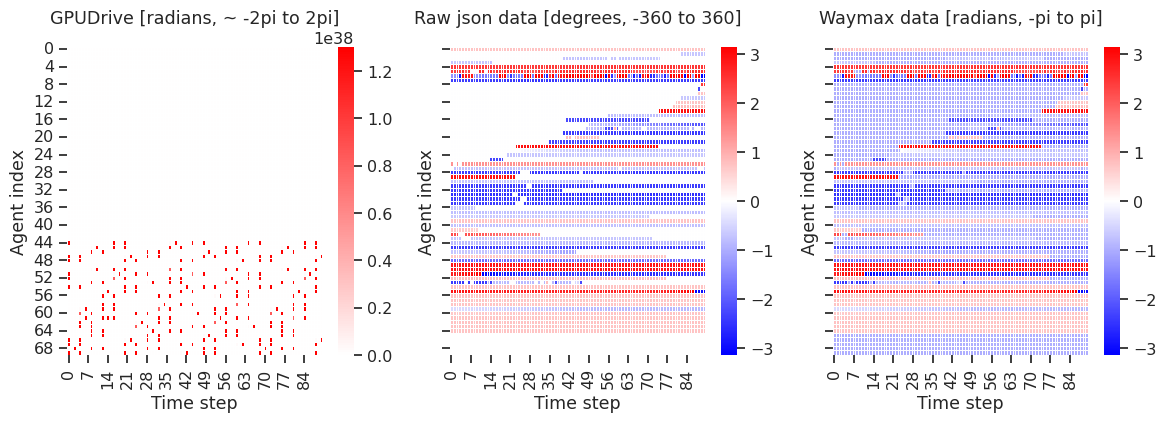

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

# GPUDrive 
sns.heatmap(sim_yaw_xy, cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[0])
axs[0].set_title('GPUDrive [radians, ~ -2pi to 2pi]', y=1.05)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Agent index')

# Raw json data 
sns.heatmap(wrap_yaws(json_yaws)[gpudrive_sorted_agent_idx], cmap=CMAP, linewidth=.5, cbar=True, annot=False, ax=axs[1])
axs[1].set_title('Raw json data [degrees, -360 to 360]', y=1.05)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Agent index')

# Waymax VBD data 
sns.heatmap(waymax_scenario.log_trajectory.yaw[waymax_sorted_agent_idx], cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[2])
axs[2].set_title('Waymax data [radians, -pi to pi]', y=1.05)
axs[2].set_ylabel('Agent index')
axs[2].set_xlabel('Time step');

In [ ]:
np.allclose()

In [40]:
json_yaws.min(), json_yaws.max()

(-142.37026622968668, 574.386069648543)

### Velocities comparison (`x` and `y`


In [44]:
json_vel_x = []
json_vel_y = []

for obj in json_scenario['objects']:
    if 'velocity' in obj:
        
        json_vel_x.append([obj['velocity'][time_step]['x'] for time_step in range(TRAJ_LEN)])
        json_vel_y.append([obj['velocity'][time_step]['y'] for time_step in range(TRAJ_LEN)])
            
json_vel_y = np.array(json_vel_y)
json_vel_x = np.array(json_vel_x)

In [45]:
sim_vel_xy[:, :, 0].shape, json_vel_x.shape, 

(torch.Size([70, 91]), (65, 91))

In [80]:
json_scenario['objects'][0]['velocity'][0]['x']

-1.00341796875

/home/emerge/.pyenv/versions/3.10.12/envs/gdrive/lib/python3.10/site-packages/matplotlib/colors.py:1404: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/emerge/.pyenv/versions/3.10.12/envs/gdrive/lib/python3.10/site-packages/matplotlib/colors.py:1404: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/emerge/.pyenv/versions/3.10.12/envs/gdrive/lib/python3.10/site-packages/matplotlib/colors.py:1404: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


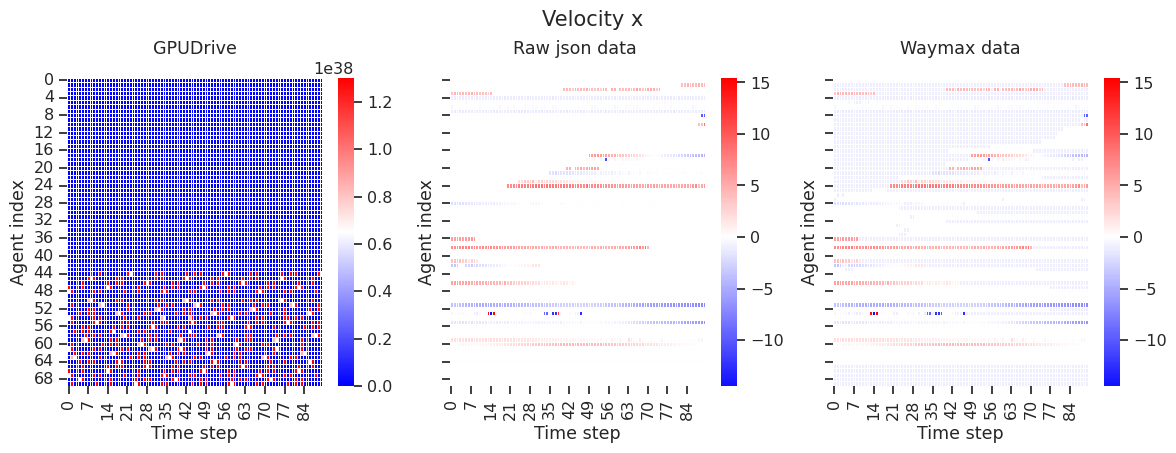

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
fig.suptitle('Velocity x', y=1.05)

# GPUDrive (vel_x)
sns.heatmap(sim_vel_xy[:, :, 0], cmap=CMAP,  linewidth=.5, cbar=True, annot=False, ax=axs[0])
axs[0].set_title('GPUDrive', y=1.05)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Agent index')

# Raw json data 
sns.heatmap(json_vel_x[gpudrive_sorted_agent_idx], center=0, cmap=CMAP, linewidth=.5, cbar=True, annot=False, ax=axs[1])
axs[1].set_title('Raw json data ', y=1.05)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Agent index')

# Waymax VBD data 
sns.heatmap(waymax_scenario.log_trajectory.vel_x[waymax_sorted_agent_idx], center=0, cmap=CMAP, linewidth=.5, cbar=True, annot=False, ax=axs[2])
axs[2].set_title('Waymax data', y=1.05)
axs[2].set_ylabel('Agent index')
axs[2].set_xlabel('Time step');

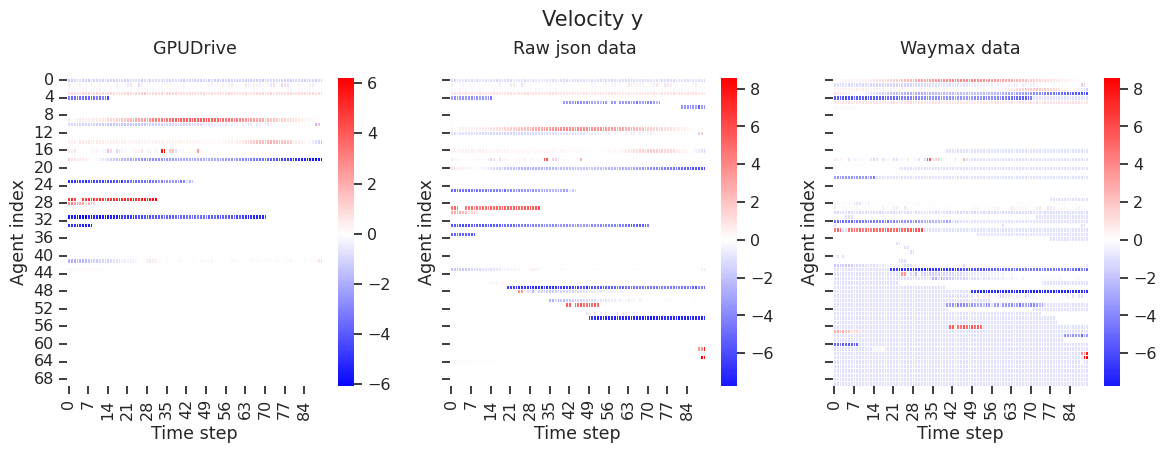

In [83]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

fig.suptitle('Velocity y', y=1.05)

# GPUDrive (vel_x)
sns.heatmap(sim_vel_xy[:, :, 1], cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[0])
axs[0].set_title('GPUDrive', y=1.05)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Agent index')

# Raw json data 
sns.heatmap(json_vel_y, cmap=CMAP, linewidth=.5, center=0, cbar=True, annot=False, ax=axs[1])
axs[1].set_title('Raw json data ', y=1.05)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Agent index')

# Waymax VBD data 
sns.heatmap(waymax_scenario.log_trajectory.vel_y, cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[2])
axs[2].set_title('Waymax data', y=1.05)
axs[2].set_ylabel('Agent index')
axs[2].set_xlabel('Time step');

### Valid

- The valid flag

In [92]:
waymax_scenario.log_trajectory.valid.shape

(70, 91)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)

fig.suptitle('Velocity y', y=1.05)

# GPUDrive (vel_x)
sns.heatmap(json_scenario, cmap=CMAP, center=0, linewidth=.5, cbar=True, annot=False, ax=axs[0])
axs[0].set_title('GPUDrive', y=1.05)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Agent index')

# Raw json data 
sns.heatmap(waymax_scenario.log_trajectory.valid  , cmap=CMAP, linewidth=.5, center=0, cbar=True, annot=False, ax=axs[1])
axs[1].set_title('Raw json data ', y=1.05)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Agent index')


In [95]:
json_scenario['objects'][0]

{'position': [{'x': 2969.4130859375,
   'y': -1056.217041015625,
   'z': -91.34427417095603},
  {'x': 2969.285888671875, 'y': -1056.34619140625, 'z': -91.3615191230925},
  {'x': 2969.16259765625, 'y': -1056.4564208984375, 'z': -91.36702167284503},
  {'x': 2969.025390625, 'y': -1056.5528564453125, 'z': -91.34170254950998},
  {'x': 2968.915771484375, 'y': -1056.6341552734375, 'z': -91.32568023401778},
  {'x': 2968.799072265625, 'y': -1056.7547607421875, 'z': -91.31358356233504},
  {'x': 2968.693603515625, 'y': -1056.8521728515625, 'z': -91.31286837500207},
  {'x': 2968.580322265625, 'y': -1056.984130859375, 'z': -91.3173122727283},
  {'x': 2968.47802734375, 'y': -1057.07958984375, 'z': -91.3149444885254},
  {'x': 2968.359130859375, 'y': -1057.2008056640625, 'z': -91.32032321166993},
  {'x': 2968.253173828125, 'y': -1057.30126953125, 'z': -91.3226008354515},
  {'x': 2968.131591796875, 'y': -1057.4027099609375, 'z': -91.31809626510454},
  {'x': 2968.01171875, 'y': -1057.5137939453125, 'z':

In [94]:
json_valid = []

for obj in json_scenario['objects']:
    if 'valid' in obj:
        
        json_valid.append([obj['valid'][time_step]['x'] for time_step in range(TRAJ_LEN)])
            
json_valid = np.array(json_valid)

[{'position': [{'x': 2969.4130859375,
    'y': -1056.217041015625,
    'z': -91.34427417095603},
   {'x': 2969.285888671875, 'y': -1056.34619140625, 'z': -91.3615191230925},
   {'x': 2969.16259765625, 'y': -1056.4564208984375, 'z': -91.36702167284503},
   {'x': 2969.025390625, 'y': -1056.5528564453125, 'z': -91.34170254950998},
   {'x': 2968.915771484375, 'y': -1056.6341552734375, 'z': -91.32568023401778},
   {'x': 2968.799072265625, 'y': -1056.7547607421875, 'z': -91.31358356233504},
   {'x': 2968.693603515625, 'y': -1056.8521728515625, 'z': -91.31286837500207},
   {'x': 2968.580322265625, 'y': -1056.984130859375, 'z': -91.3173122727283},
   {'x': 2968.47802734375, 'y': -1057.07958984375, 'z': -91.3149444885254},
   {'x': 2968.359130859375, 'y': -1057.2008056640625, 'z': -91.32032321166993},
   {'x': 2968.253173828125, 'y': -1057.30126953125, 'z': -91.3226008354515},
   {'x': 2968.131591796875, 'y': -1057.4027099609375, 'z': -91.31809626510454},
   {'x': 2968.01171875, 'y': -1057.5137

### Road points comparison (todo)

### 